In [14]:
!pip install mne

     ---------------------------------------- 7.4/7.4 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 KB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 64.6/64.6 KB 3.4 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\Ana-Sophia Redstone\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [27]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert

In [28]:
# ====== CONFIGURACIÓN ======
edf_path = r"C:\Users\Ana-Sophia Redstone\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)

In [29]:
# ====== CARGA Y PREPROCESAMIENTO ======
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\Ana-Sophia Redstone\OneDrive\Documents\GitHub\Neurociencias-2026-1\S03_datasets\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...
Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method


C:\Users\Ana-Sophia Redstone\AppData\Local\Temp\ipykernel_17820\1692581060.py:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [30]:
data

array([[-6.26804381e-20,  9.96691423e-05,  1.56464544e-04, ...,
        -3.25461886e-05, -2.44063872e-05, -3.38813179e-21],
       [ 0.00000000e+00,  7.14210275e-05,  1.12391959e-04, ...,
        -5.47231902e-06, -1.78326784e-06, -1.10114283e-20],
       [-8.47032947e-21,  3.00249387e-05,  4.62387169e-05, ...,
         1.76838641e-05,  1.13131737e-05, -8.47032947e-22],
       ...,
       [-5.08219768e-20,  1.84483340e-04,  2.87170890e-04, ...,
         3.62255574e-05,  1.60453355e-05,  5.08219768e-21],
       [-1.10114283e-20, -6.40667792e-05, -1.01071351e-04, ...,
         7.34684870e-06,  1.44976840e-06, -1.27054942e-21],
       [ 1.86347248e-20, -3.08754614e-05, -4.79904833e-05, ...,
        -8.25147645e-06, -5.29050421e-06,  1.16467030e-21]],
      shape=(23, 921600))

In [31]:
ch_names

['FP1-F7',
 'F7-T7',
 'T7-P7',
 'P7-O1',
 'FP1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'FP2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'FP2-F8',
 'F8-T8',
 'T8-P8-0',
 'P8-O2',
 'FZ-CZ',
 'CZ-PZ',
 'P7-T7',
 'T7-FT9',
 'FT9-FT10',
 'FT10-T8',
 'T8-P8-1']

In [32]:
n_channels

23

In [33]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)

In [34]:
corr_df.head(3)

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
FP1-F7,1.000000,0.103592,-0.070391,0.008550,0.792282,0.402987,0.221081,0.130110,0.744005,0.462771,...,0.487322,0.003882,0.100852,0.437392,0.210561,0.070391,0.282011,-0.246338,-0.040157,0.003882
F7-T7,0.103592,1.000000,0.138700,0.005079,0.491057,0.419551,0.195553,0.135568,0.384312,0.217138,...,0.137333,0.091827,-0.043687,0.309492,0.211246,-0.138700,-0.599087,0.395563,-0.099850,0.091827
T7-P7,-0.070391,0.138700,1.000000,0.149314,0.118458,0.308218,0.338679,0.291802,0.102540,0.161603,...,0.063399,0.326646,0.051256,0.224985,0.272034,-1.000000,0.100195,0.261074,-0.060052,0.326646


In [35]:
plv_df.head(3)

,FP1-F7,F7-T7,T7-P7,P7-O1,FP1-F3,F3-C3,C3-P3,P3-O1,FP2-F4,F4-C4,...,F8-T8,T8-P8-0,P8-O2,FZ-CZ,CZ-PZ,P7-T7,T7-FT9,FT9-FT10,FT10-T8,T8-P8-1
FP1-F7,1.000000,0.074626,0.055968,0.060709,0.624161,0.173790,0.049846,0.009869,0.367289,0.181558,...,0.192038,0.053695,0.096780,0.168444,0.115015,0.055968,0.171844,0.258160,0.017905,0.053695
F7-T7,0.074626,1.000000,0.164502,0.034743,0.296048,0.428383,0.312913,0.085794,0.228681,0.197666,...,0.141999,0.112061,0.030763,0.250845,0.221533,0.164502,0.477853,0.145628,0.029596,0.112061
T7-P7,0.055968,0.164502,1.000000,0.200252,0.095674,0.290597,0.439663,0.271496,0.101994,0.182175,...,0.114757,0.295218,0.104128,0.229491,0.265747,1.000000,0.071008,0.193829,0.071853,0.295218


In [36]:
corr_df.columns

Index(['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3',
       'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8',
       'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10',
       'FT10-T8', 'T8-P8-1'],
      dtype='object')

## Actividades de clase
Generar el mapa de calor de cada matriz de conectividad

Generar la distribución de datos de cada matriz de conectividad

¿Qué valor se encuentra en el percentil 0.75 de cada matriz de conectividad?

Generar el grafo 2D de cada matriz de conectividad y compararlos

Generar el grafo 3D de cada matriz de conectividad y compararlos

In [37]:
pd.Series(corr_df.values.flatten()).describe()

count    529.000000
mean       0.183955
std        0.305673
min       -1.000000
25%        0.019899
50%        0.143003
75%        0.329381
max        1.000000
dtype: float64

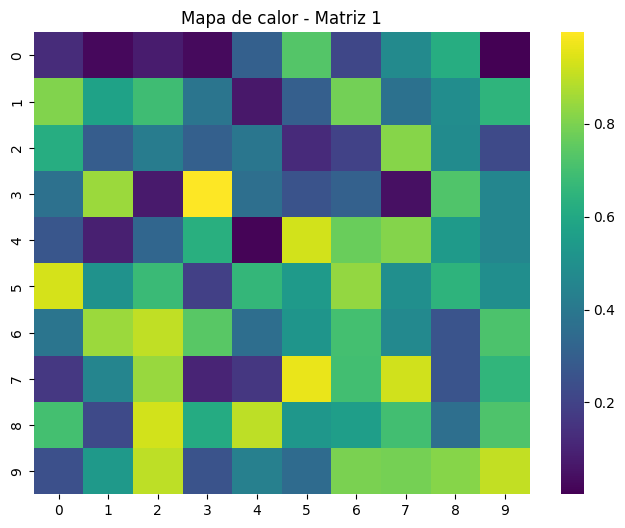

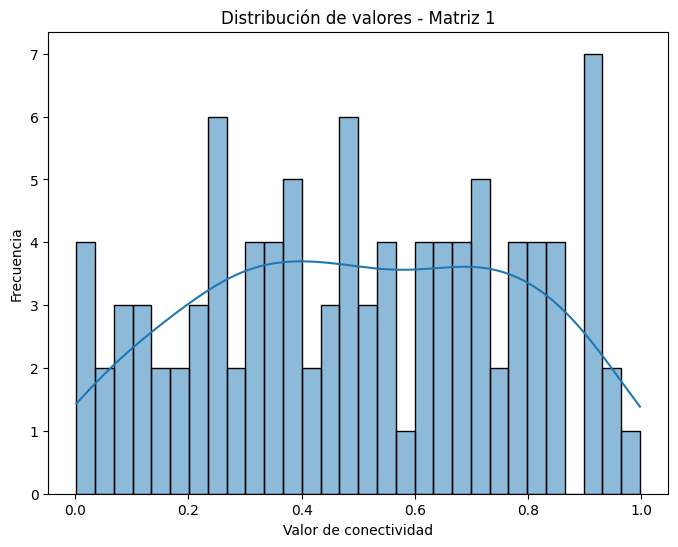

El valor en el percentil 0.75 de la matriz 1 es: 0.7189733673358778


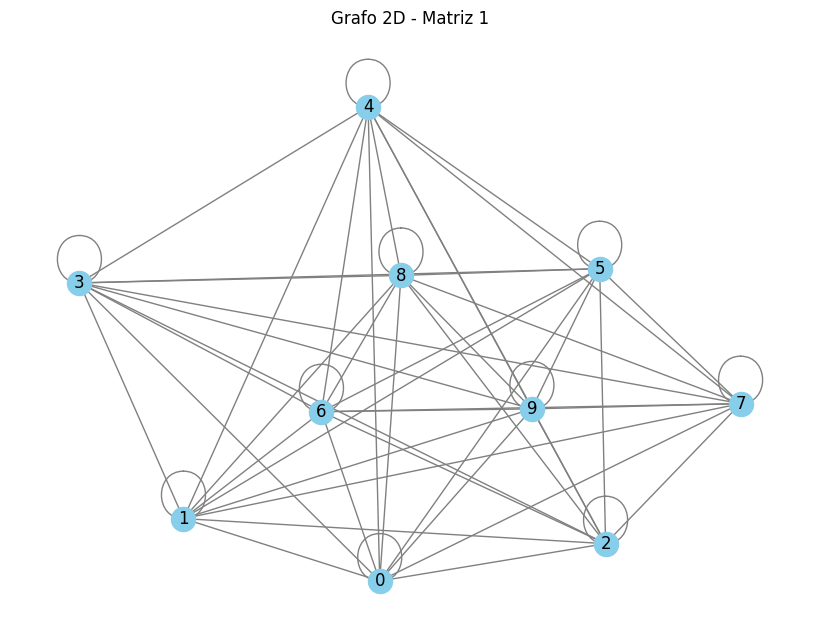

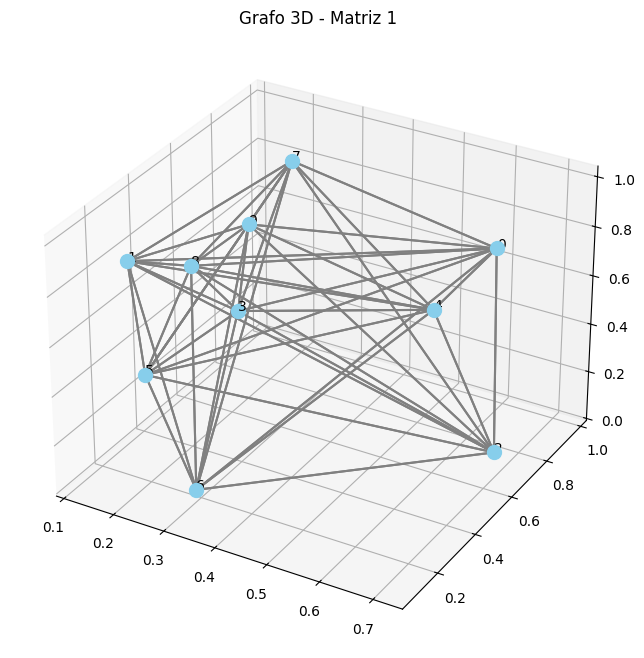

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

# definir matriz para que cargue y corra bien 
matriz1 = np.random.rand(10, 10)  # OJO PIOJOO lo estoy haciendo así porque no se si , si era con datos o  no 

# Mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz1, cmap='viridis', annot=False)
plt.title('Mapa de calor - Matriz 1')
plt.show()

# Distribución
valores1 = matriz1.flatten()
plt.figure(figsize=(8, 6))
sns.histplot(valores1, bins=30, kde=True)
plt.title('Distribución de valores - Matriz 1')
plt.xlabel('Valor de conectividad')
plt.ylabel('Frecuencia')
plt.show()

# Percentil 0.75
percentil_75 = np.percentile(valores1, 75)
print(f"El valor en el percentil 0.75 de la matriz 1 es: {percentil_75}")

# Grafo 2D
G1 = nx.from_numpy_array(matriz1)
plt.figure(figsize=(8, 6))
nx.draw(G1, with_labels=True, node_color='skyblue', edge_color='gray')
plt.title('Grafo 2D - Matriz 1')
plt.show()

# Grafo 3D
pos_3d = {i: np.random.rand(3) for i in range(len(matriz1))}
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, j in zip(*np.where(matriz1 > 0)):
    x = [pos_3d[i][0], pos_3d[j][0]]
    y = [pos_3d[i][1], pos_3d[j][1]]
    z = [pos_3d[i][2], pos_3d[j][2]]
    ax.plot(x, y, z, color='gray')

for i in pos_3d:
    ax.scatter(*pos_3d[i], color='skyblue', s=100)
    ax.text(*pos_3d[i], str(i), fontsize=10)

ax.set_title('Grafo 3D - Matriz 1')
plt.show()
